This notebook creates a NN to make predictions based on pre-existing data.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os
import pandas as pd
import oracledb
from sklearn.model_selection import train_test_split
import tensorflow as tf

from fastai.tabular.all import *

2022-06-27 19:08:33.020011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 19:08:33.020067: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
os.environ['PATH']='/home/ubuntu/miniconda3/bin:$PATH'

In [3]:
import yaml
from pathlib import Path
home = str(Path.home())

def process_yaml():
	with open("../config.yaml") as file:
		return yaml.safe_load(file)

class OracleJSONDatabaseThickConnection:
    def __init__(self, data=process_yaml()):
        oracledb.init_oracle_client(lib_dir=data['INSTANT_CLIENT'])
        self.pool = oracledb.create_pool(user=data['db']['username'], password=data['db']['password'], dsn=data['db']['dsn'],
            min=1, max=4, increment=1, getmode=oracledb.POOL_GETMODE_WAIT)
        print('Connection successful.')



    def close_pool(self):
        self.pool.close()
        print('Connection pool closed.')



    def insert(self, collection_name, json_object_to_insert):
        connection = self.pool.acquire()
        connection.autocommit = True
        soda = connection.getSodaDatabase()
        x_collection = soda.createCollection(collection_name)

        try:
            x_collection.insertOne(json_object_to_insert)
            print('[DBG] INSERT {} OK'.format(json_object_to_insert))
        except oracledb.IntegrityError as e:
            print('[DBG] INSERT {} ERR: {} '.format(json_object_to_insert, e))
            return -1
        self.pool.release(connection)
        return 1


    def delete(self, collection_name, on_column, on_value):
        connection = self.pool.acquire()
        connection.autocommit = True
        soda = connection.getSodaDatabase()
        x_collection = soda.createCollection(collection_name)
        qbe = {on_column: on_value}
        x_collection.find().filter(qbe).remove()
        self.pool.release(connection)


    def get_connection(self):
        connection = self.pool.acquire()
        connection.autocommit = True
        return connection


    def close_connection(self, conn_object):
        self.pool.release(conn_object)


    def get_collection_names(self):
        connection = self.pool.acquire()
        connection.autocommit = True
        returning_object = connection.getSodaDatabase().getCollectionNames(startName=None, limit=0)
        self.pool.release(connection)
        return returning_object

    def open_collection(self, collection_name):
        connection = self.pool.acquire()
        returning_object = self.pool.acquire().getSodaDatabase().openCollection(collection_name)
        self.pool.release(connection)
        return returning_object

In [4]:
db = OracleJSONDatabaseThickConnection()
print(db.get_collection_names())

Connection successful.
['1v1_model', 'match', 'match_detail', 'matchups', 'predictor', 'predictor_liveclient', 'summoner']


In [5]:
data = db.open_collection('predictor_liveclient')
all_data = list()
i = 0
for doc in data.find().getCursor():
    content = doc.getContent()
    all_data.append(content)
    i+= 1
    if i>500000:
        break

print('Data length: {}'.format(len(all_data)))

Data length: 500001


In [6]:
df = pd.read_json(json.dumps(all_data), orient='records')

df.head(5)

,winner,magicResist,healthRegenRate,spellVamp,timestamp,bonusArmorPenetrationPercent,bonusMagicPenetrationPercent,maxHealth,identifier,moveSpeed,...,cooldownReduction,resourceValue,magicPenetrationFlat,attackSpeed,currentHealth,armor,magicPenetrationPercent,armorPenetrationFlat,resourceMax,resourceRegenRate
0,0,31,20,0,360110,0,0,808,EUW1_5324066926_8,335,...,0,780,0,116,805,41,0,0,1304,20
1,0,31,9,0,360110,0,0,796,EUW1_5324066926_9,330,...,0,311,0,123,796,36,0,0,311,15
2,0,31,18,0,360110,0,0,722,EUW1_5324066926_10,355,...,0,539,0,105,722,43,0,0,574,37
3,1,31,13,0,420122,0,0,957,EUW1_5324066926_1,350,...,0,976,0,119,957,43,0,0,1123,22
4,1,36,21,0,420122,0,0,933,EUW1_5324066926_2,345,...,0,204,6,174,393,54,0,0,491,18


In [7]:
# convert to CSV format in case we want to reuse and stop flooding the database with requests (e.g. work offline)
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html


In [8]:
df.columns

Index(['winner', 'magicResist', 'healthRegenRate', 'spellVamp', 'timestamp',
       'bonusArmorPenetrationPercent', 'bonusMagicPenetrationPercent',
       'maxHealth', 'identifier', 'moveSpeed', 'attackDamage',
       'armorPenetrationPercent', 'lifesteal', 'abilityPower',
       'cooldownReduction', 'resourceValue', 'magicPenetrationFlat',
       'attackSpeed', 'currentHealth', 'armor', 'magicPenetrationPercent',
       'armorPenetrationFlat', 'resourceMax', 'resourceRegenRate'],
      dtype='object')

In [9]:
df.describe()

,winner,magicResist,healthRegenRate,spellVamp,timestamp,bonusArmorPenetrationPercent,bonusMagicPenetrationPercent,maxHealth,moveSpeed,attackDamage,...,cooldownReduction,resourceValue,magicPenetrationFlat,attackSpeed,currentHealth,armor,magicPenetrationPercent,armorPenetrationFlat,resourceMax,resourceRegenRate
count,500001.000000,500001.000000,500001.000000,500001.000000,5.000010e+05,500001.0,500001.0,500001.000000,500001.000000,500001.000000,...,500001.0,500001.000000,500001.000000,500001.000000,500001.000000,500001.000000,500001.000000,500001.0,500001.000000,500001.000000
mean,0.499995,45.230798,42.798886,0.053988,8.653074e+05,0.0,0.0,1374.888026,382.149592,122.503017,...,0.0,691.217656,2.245048,140.992862,1018.089738,69.230000,0.567335,0.0,880.773324,42.255191
std,0.500000,21.318158,93.514058,0.984840,5.596643e+05,0.0,0.0,620.028426,60.203930,75.690522,...,0.0,1264.604354,6.924246,44.421171,672.306458,38.736863,3.708703,0.0,1294.398469,49.589415
min,0.000000,-10.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,340.000000,0.000000,1.000000,...,0.0,0.000000,0.000000,50.000000,0.000000,-14.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,33.000000,16.000000,0.000000,4.200980e+05,0.0,0.0,890.000000,345.000000,73.000000,...,0.0,245.000000,0.000000,112.000000,561.000000,45.000000,0.000000,0.0,400.000000,17.000000
50%,0.000000,38.000000,23.000000,0.000000,8.402260e+05,0.0,0.0,1291.000000,375.000000,93.000000,...,0.0,441.000000,0.000000,125.000000,946.000000,59.000000,0.000000,0.0,637.000000,26.000000
75%,1.000000,47.000000,35.000000,0.000000,1.260434e+06,0.0,0.0,1722.000000,395.000000,154.000000,...,0.0,745.000000,0.000000,154.000000,1437.000000,81.000000,0.000000,0.0,953.000000,48.000000
max,1.000000,492.000000,5682.000000,37.000000,3.147362e+06,0.0,0.0,7019.000000,1224.000000,811.000000,...,0.0,10000.000000,50.000000,621.000000,6921.000000,836.000000,48.000000,0.0,10000.000000,1150.000000


In [10]:
# drop columns we don't want (constant values + identifier)
df.drop(columns=['bonusArmorPenetrationPercent', 'bonusMagicPenetrationPercent',
    'identifier', 'cooldownReduction', 'armorPenetrationFlat'], axis=1, inplace=True)

label = 'winner'

In [11]:
df.head(5)

,winner,magicResist,healthRegenRate,spellVamp,timestamp,maxHealth,moveSpeed,attackDamage,armorPenetrationPercent,lifesteal,abilityPower,resourceValue,magicPenetrationFlat,attackSpeed,currentHealth,armor,magicPenetrationPercent,resourceMax,resourceRegenRate
0,0,31,20,0,360110,808,335,62,0,0,9,780,0,116,805,41,0,1304,20
1,0,31,9,0,360110,796,330,103,0,10,0,311,0,123,796,36,0,311,15
2,0,31,18,0,360110,722,355,52,0,0,14,539,0,105,722,43,0,574,37
3,1,31,13,0,420122,957,350,97,0,1,0,976,0,119,957,43,0,1123,22
4,1,36,21,0,420122,933,345,109,0,0,0,204,6,174,393,54,0,491,18


In [12]:
all_columns = list()
for x in df.columns:
    all_columns.append(x) # Index() to list()

print(all_columns)

['winner', 'magicResist', 'healthRegenRate', 'spellVamp', 'timestamp', 'maxHealth', 'moveSpeed', 'attackDamage', 'armorPenetrationPercent', 'lifesteal', 'abilityPower', 'resourceValue', 'magicPenetrationFlat', 'attackSpeed', 'currentHealth', 'armor', 'magicPenetrationPercent', 'resourceMax', 'resourceRegenRate']


In [13]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df)) # 80-20 split

dls = TabularDataLoaders.from_df(df=df,
                   procs=[Categorify, FillMissing, Normalize],
                   cat_names = None,
                   cont_names = ['magicResist', 'healthRegenRate', 'spellVamp', 'timestamp',
                                 'maxHealth', 'moveSpeed', 'attackDamage', 'armorPenetrationPercent',
                                 'lifesteal', 'abilityPower', 'resourceValue', 'magicPenetrationFlat',
                                 'attackSpeed', 'currentHealth', 'armor', 'magicPenetrationPercent',
                                 'resourceMax', 'resourceRegenRate'],
                    y_names=label,
                    y_block = CategoryBlock([0.0, 1.0]),
                    splits=splits,
                    bs=64)

In [14]:
df.iloc[:5]

,winner,magicResist,healthRegenRate,spellVamp,timestamp,maxHealth,moveSpeed,attackDamage,armorPenetrationPercent,lifesteal,abilityPower,resourceValue,magicPenetrationFlat,attackSpeed,currentHealth,armor,magicPenetrationPercent,resourceMax,resourceRegenRate
0,0,31,20,0,360110,808,335,62,0,0,9,780,0,116,805,41,0,1304,20
1,0,31,9,0,360110,796,330,103,0,10,0,311,0,123,796,36,0,311,15
2,0,31,18,0,360110,722,355,52,0,0,14,539,0,105,722,43,0,574,37
3,1,31,13,0,420122,957,350,97,0,1,0,976,0,119,957,43,0,1123,22
4,1,36,21,0,420122,933,345,109,0,0,0,204,6,174,393,54,0,491,18


In [15]:
print(df.dtypes)

In [16]:
dls.show_batch(max_n=10, show=True, unique=True)

,magicResist,healthRegenRate,spellVamp,timestamp,maxHealth,moveSpeed,attackDamage,armorPenetrationPercent,lifesteal,abilityPower,resourceValue,magicPenetrationFlat,attackSpeed,currentHealth,armor,magicPenetrationPercent,resourceMax,resourceRegenRate,winner
0,30.000000,4.177104e-07,5.023301e-10,-2.728602e-02,605.000027,329.999999,24.999996,2.994612e-09,-2.178762e-08,-5.810302e-07,360.000005,6.665004e-08,100.000000,605.000001,29.000000,3.400172e-09,360.000016,-0.000001,0.0
1,35.000000,2.600000e+01,5.023301e-10,1.320351e+06,1507.999996,385.000000,89.000001,2.994612e-09,-2.178762e-08,1.130000e+02,1970.999927,2.400000e+01,131.000000,1507.999982,98.000000,3.400172e-09,2518.000037,33.000000,0.0
2,45.000000,3.700000e+01,5.023301e-10,1.140312e+06,1805.000000,404.000000,90.000000,2.994612e-09,-2.178762e-08,2.530000e+02,1046.000003,2.400000e+01,136.000000,1805.000024,70.000000,3.400172e-09,1046.000005,186.000002,1.0
3,95.000001,3.000000e+01,5.023301e-10,1.560407e+06,2165.000036,390.000000,268.000003,5.000000e+00,-2.178762e-08,-5.810302e-07,1410.000033,6.665004e-08,155.000000,0.000020,124.000001,5.000000e+00,1793.999964,67.999999,0.0
4,30.000000,1.110000e+02,5.023301e-10,1.800410e+05,560.999988,329.999999,56.000000,2.994612e-09,-2.178762e-08,2.600000e+01,157.999986,6.665004e-08,100.000000,480.000013,26.999999,3.400172e-09,571.000002,25.000000,0.0
5,31.000000,1.500000e+01,5.023301e-10,2.400720e+05,747.000022,334.999998,52.999998,2.994612e-09,-2.178762e-08,1.800000e+01,438.999993,6.665004e-08,104.000000,710.000010,31.000000,3.400172e-09,535.999988,139.999998,1.0
6,53.000000,1.410000e+02,5.023301e-10,1.260344e+06,1805.000000,404.000000,90.000000,2.994612e-09,-2.178762e-08,2.130000e+02,643.000002,2.400000e+01,136.000000,706.999996,64.000000,3.400172e-09,1046.000005,94.000000,0.0
7,32.000000,1.500000e+01,5.023301e-10,7.802240e+05,1117.999994,350.000000,189.000002,2.994612e-09,3.000000e+00,-5.810302e-07,1419.000036,6.665004e-08,174.000001,1096.000002,50.000000,3.400172e-09,1717.999988,52.000000,0.0
8,33.000000,1.180000e+02,5.023301e-10,5.402270e+05,773.000015,380.000000,60.000002,2.994612e-09,-2.178762e-08,2.400000e+01,283.999986,6.665004e-08,107.999999,773.000003,50.000000,3.400172e-09,747.000003,44.000000,1.0
9,38.000000,2.300000e+01,5.023301e-10,5.401550e+05,995.999995,340.000001,124.000000,2.994612e-09,-2.178762e-08,-5.810302e-07,605.000002,6.665004e-08,113.000000,895.999995,59.000000,3.400172e-09,652.000005,160.000004,1.0


In [17]:
learn = tabular_learner(dls,
    layers=[1000, 500],
    metrics=[accuracy]
)

In [18]:
learn.lr_find()

In [ ]:
learn.summary()

In [19]:
learn.fit_one_cycle(250) #.fit(150, lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.672380,0.669016,0.578950,00:47
1,0.667673,0.666015,0.583190,00:49
2,0.670871,0.665980,0.584840,01:18
3,0.660563,0.663251,0.588100,01:19
4,0.661535,0.662787,0.584650,01:20
5,0.665265,0.660765,0.589300,01:20
6,0.668309,0.664257,0.586340,01:26
7,0.658979,0.660190,0.588230,01:18
8,0.662171,0.661718,0.587460,01:18
9,0.665512,0.658829,0.590850,01:21


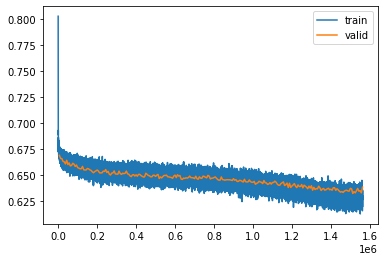

In [21]:
learn.recorder.plot_loss()

In [22]:
learn.show_results()

,magicResist,healthRegenRate,spellVamp,timestamp,maxHealth,moveSpeed,attackDamage,armorPenetrationPercent,lifesteal,abilityPower,resourceValue,magicPenetrationFlat,attackSpeed,currentHealth,armor,magicPenetrationPercent,resourceMax,resourceRegenRate,winner,winner_pred
0,1.817327,0.149912,-0.05478,0.920037,0.955453,1.574105,-0.403063,-0.200568,-0.350872,-0.301521,0.226815,-0.324425,-0.742555,1.412825,1.563914,-0.15299,0.074438,-0.267471,1.0,1.0
1,-0.011031,-0.115328,-0.05478,1.027145,1.145662,-0.036765,-0.297280,-0.200568,-0.350872,1.843361,0.669760,3.856834,1.352989,1.588314,1.306387,-0.15299,0.544987,4.039211,0.0,1.0
2,-0.386079,2.791702,-0.05478,0.812698,0.355810,0.378408,-0.429509,-0.200568,-0.350872,0.863727,0.666584,2.270839,-0.584826,0.859587,0.070259,-0.15299,0.503901,3.817840,0.0,0.0
3,-0.573603,0.775878,-0.05478,-0.795744,-0.729028,-2.976187,-0.746858,-0.200568,-0.350872,0.245011,-0.308212,-0.324425,-0.810153,-1.226953,-1.088610,-0.15299,0.118625,-0.408344,1.0,1.0
4,-0.526722,-0.210815,-0.05478,1.456275,0.304228,-0.202834,-0.508846,-0.200568,-0.350872,0.750296,0.141878,-0.324425,-0.742555,0.609738,-0.470546,-0.15299,0.124826,1.503501,1.0,0.0
5,-0.620484,-0.285082,-0.05478,-1.439151,-1.298045,-0.618006,-0.680744,-0.200568,-0.350872,-0.507760,-0.330438,-0.324425,-0.697489,-0.666279,-0.728073,-0.15299,-0.469756,-0.569342,0.0,1.0
6,-0.573603,-0.285082,-0.05478,0.169410,0.367093,-0.202834,0.099406,-0.200568,1.312919,-0.507760,0.170455,-0.324425,-0.336966,0.869997,-0.419041,-0.15299,0.539561,-0.347970,1.0,1.0
7,-0.198555,1.380625,-0.05478,0.062111,0.568586,-0.202834,0.641544,-0.200568,-0.350872,-0.507760,-0.502694,-0.324425,0.068624,-0.147246,0.430797,-0.15299,-0.604642,-0.851087,1.0,1.0
8,-0.479841,-0.306301,-0.05478,0.276469,-0.135833,-0.451937,1.712598,-0.200568,0.599866,-0.507760,-0.093090,-0.324425,-0.201769,-1.513982,-0.341783,-0.15299,-0.188356,-0.408344,0.0,0.0


In [23]:
row, clas, probs = learn.predict(df.iloc[0])

In [26]:
print('Winning probability: {}%, losing probability: {}%'.format(probs[0].item(), probs[1].item()))

Winning probability: 0.5361863970756531%, losing probability: 0.46381357312202454%


In [27]:
ds_aggregator = list()

for x in range(10):
    row, clas, probs = learn.predict(df.iloc[x+50])
    del row, clas
    ds_aggregator.append(probs[0].item()) # aggregate winning probabilities

import statistics
result = statistics.mean(ds_aggregator)

print('Combined weighted winning probability: {}'.format(result))

Combined weighted winning probability: 0.5464715272188186


In [ ]:
'''
Inference on a test set:

Now that we have a model, we want to make our final competitions that would be submitted to a competition, as such, we can only make the predictions and submit them as a CSV.

We'll practice bringing in an exported model just to show that you do not need the original data.
'''

In [ ]:
learn.export('liveclient_model')

del learn

learn = load_learner('liveclient_model')



'''Now we generate our test_dl from our test_df'''
dl = learn.dls.test_dl(df)

'''

We need to tell the Learner to return the predictions for the test set we added
'''


raw_test_preds = learn.get_preds(dl=dl)



In [ ]:
raw_test_preds

'''You'll notice [0] contains our predictions, and [1] contains any labels (if we had any). This is nice because if we accidently run learn.validate() on a non-labeled test set, we get the following:'''

In [ ]:
learn.validate(dl=dl)

In [ ]:
test_preds = raw_test_preds[0].numpy().T[0]

print(test_preds)

In [ ]:
'''
Permutation importance is a technique in which we shuffle
each column in a dataframe and analyze how changing a particular
column affected our y values. The more that it was affected,
the more "important" we can (generally) call a variable in our
neural network.
Let's build a quick algorithm to do this:
'''

class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df
    bs = bs if bs is not None else learn.dls.bs
    if self.df is not None:
      self.dl = learn.dls.test_dl(self.df, bs=bs)
    else:
      self.dl = learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[1]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[1]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = (base_error-value)/base_error #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=20, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

In [ ]:
# And now we can simply call PermutationImportance to run it!
res = PermutationImportance(learn, df.iloc[:1000], bs=64)

In [ ]:
res.importance